# Spatial Regression

This notebook illustrates fitting a Guassian process for daily average Nitrous Oxide levels with data from all sites on date number 103.

## 0. Prepare Environment

In [1]:
# Import external packages
import numpy as np
import pandas as pd

In [2]:
# Import spatial Gaussian process class
from stgp.SGP import SGP

## 1. Load Dataset

In [3]:
# Load air quality dataset
df = pd.read_csv('..\Data processing\Daily avg air quality data 21-04-2020 to 2021 with site \
data.csv')
print(df.shape)
print(df.head())

(16104, 11)
                Site  Lat.South  Long.East  Alt.AHD  Date  PM10.24h.mcrg.m3  \
0             ALBURY  -36.05183  146.93980      182     1               NaN   
1              BARGO  -34.30630  150.58060      365     1               NaN   
2           BATHURST  -33.40192  149.57459      625     1               NaN   
3         BERESFIELD  -32.79679  151.66102       14     1               NaN   
4  BRADFIELD HIGHWAY  -33.84343  151.21142       36     1               NaN   

   CO.24h.ppm  SO2.24h.pphm  NO.24h.pphm  NO2.24h.pphm  OZONE.24h.pphm.1  
0         NaN           NaN          NaN           NaN               NaN  
1         NaN           0.1          1.2           1.0               1.3  
2         NaN           NaN          NaN           NaN               NaN  
3         NaN           0.3          0.9           1.0               1.0  
4         0.2           0.2          5.3           2.7               0.5  


Check spatial distribution.

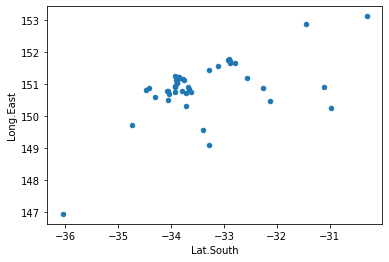

In [4]:
df[df['Date'] == 103].plot(x = 'Lat.South', y = 'Long.East', kind = 'scatter');

In [5]:
# Set parameters
target_var = 'NO2.24h.pphm'
target_name = "Nitrous Oxide"
cov_func_name = "Squared exponential"
long_low = 146
long_up = 154
lat_low = -37
lat_up = -30
date = 103

## 2. Type II Likelihood Maximisation

In [6]:
# Create Gaussian process object - Have to update hyperparameter initialisation for ARD (multiple lengthscales)
sgp = SGP(df, target_var, target_name, long_low, long_up, lat_low, lat_up, 
          date, cov_func_name)

# # Make bounds for optimiser (log-scale)
bounds = ((np.log(0.5 * sgp.hyper_params[0]), np.log(2 * sgp.hyper_params[0])), 
          (np.log(0.5 * sgp.hyper_params[1]), np.log(2 * sgp.hyper_params[1])), 
          (np.log(0.5 * sgp.sigma_n), np.log(2 * sgp.sigma_n)))

# Fit GP
sgp.fit(bounds = bounds)

# Plot it
sgp.plot_preds()

GP Optimising Hyper-parameters
Initial hyperparameter values: 
[0.949 0.688 0.316]
Hyperparameter bounds:
[[0.474 0.344 0.158]
 [1.897 1.377 0.632]]
Optimisation results: 
[0.734 0.345 0.633]
Log marginal likelihood
[-46.32129409]
99.0% of data within 95% confidence interval


In [7]:
# Set parameters
cov_func_name = "ARD"

# Create Gaussian process object - Have to update hyperparameter initialisation for ARD (multiple lengthscales)
sgp = SGP(df, target_var, target_name, long_low, long_up, lat_low, lat_up, 
          date, cov_func_name)

# Make bounds for optimiser (log-scale)
bounds = ((np.log(0.5 * sgp.hyper_params[0]), np.log(2 * sgp.hyper_params[0])), 
          (np.log(0.5 * sgp.hyper_params[1]), np.log(2 * sgp.hyper_params[1])), 
          (np.log(0.5 * sgp.hyper_params[2]), np.log(2 * sgp.hyper_params[2])), 
          (np.log(0.5 * sgp.sigma_n), np.log(2 * sgp.sigma_n)))

# Fit GP
sgp.fit(bounds = bounds)

# Plot it
sgp.plot_preds()

GP Optimising Hyper-parameters
Initial hyperparameter values: 
[0.949 0.895 0.77  0.316]
Hyperparameter bounds:
[[0.474 0.447 0.385 0.158]
 [1.897 1.789 1.539 0.632]]
Optimisation results: 
[0.71  0.448 1.54  0.633]
Log marginal likelihood
[-47.64785381]
99.0% of data within 95% confidence interval


## 3. Markov Chain Monte Carlo

### 3.1 Posterior Mean

In [8]:
# Load spatial hyperparameter samples from HMC
shphmcdf = pd.read_csv('..\MCMC\D103_2D_Spatial_hyperparmeters_SquareExp.csv')
shphmcdf.columns = ["l_long", "l_lat", "sigma_f", "sigma_n"]
shphmcdf = shphmcdf[["sigma_f", "l_long", "l_lat", "sigma_n"]]
print(shphmcdf.shape)
print(shphmcdf.head())

(10000, 4)
    sigma_f    l_long     l_lat   sigma_n
0  1.509983  0.099536  0.023239  0.000008
1  1.147901  0.106499  0.019528  0.000007
2  1.143758  0.097878  0.026721  0.000007
3  1.215182  0.088635  0.025205  0.000006
4  1.270495  0.051393  0.033286  0.000007


In [9]:
# Create Gaussian process object - Have to update hyperparameter initialisation for ARD (multiple lengthscales)
sgphmc = SGP(df, target_var, target_name, long_low, long_up, lat_low, lat_up, 
          date, cov_func_name)

# Load temporal hyperparameter samples from HMC
sgphmc.load_hp_samps(shphmcdf)

# Set Gaussian process to use posterior means of hyperparameters
sgphmc.set_post_mean()
sgphmc.plot_preds()

Posterior means of hyperparameters:
sigma_f    0.621845
l_long     0.495945
l_lat      1.475499
sigma_n    0.661272
dtype: float64
99.0% of data within 95% confidence interval


### 3.2. Maximum A Posteriori

[0.32750528 0.07118799 0.20479153 0.59448368]
Maximum a posteriori estimates of hyperparameters:
['sigma_f' 'l_long' 'l_lat' 'sigma_n']
[0.32750528 0.07118799 0.20479153 0.59448368]


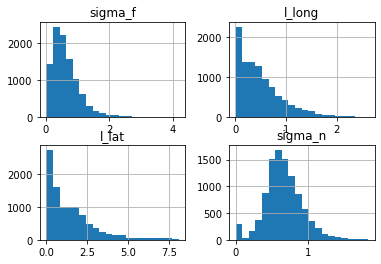

In [10]:
# Set Gaussian process to use maximum a posteriori hyperparameter values
sgphmc.set_max_post()

In [11]:
# Plot predictions from MAP hyperparameter estimates
sgphmc.plot_preds()

99.0% of data within 95% confidence interval


### 3.3. Posterior Credible Interval

In [12]:
sgphmc.plot_post()

Sampling posterior predictive distribution
sample 1
sample 101
sample 201
sample 301
sample 401
100.0% of data within 95% credible interval
Sampling posterior predictive distribution
sample 1
sample 101
sample 201
sample 301
sample 401


## 4. Variational Inference

### 4.1. Posterior Mean

In [13]:
# Load spatial hyperparameter samples from HMC
shpvidf = pd.read_csv('..\VI\VI_2D.csv')
shpvidf.columns = ["l_long", "l_lat", "sigma_f", "sigma_n"]
shpvidf = shpvidf[["sigma_f", "l_long", "l_lat", "sigma_n"]]
print(shpvidf.shape)
print(shpvidf.head())

(1000, 4)
    sigma_f    l_long     l_lat   sigma_n
0  1.134059  0.955801  1.031407  0.866286
1  1.009409  1.118263  0.864086  0.960888
2  1.163201  0.888024  0.997110  0.754735
3  1.293208  0.907973  1.070464  0.908958
4  1.055450  0.935789  0.871349  1.204200


In [14]:
# Create Gaussian process object - Have to update hyperparameter initialisation for ARD (multiple lengthscales)
sgpvi = SGP(df, target_var, target_name, long_low, long_up, lat_low, lat_up, 
          date, cov_func_name)

# Load temporal hyperparameter samples from HMC
sgpvi.load_hp_samps(shpvidf)

# Set Gaussian process to use posterior means of hyperparameters
sgpvi.set_post_mean()
sgpvi.plot_preds()

Posterior means of hyperparameters:
sigma_f    1.017670
l_long     1.003843
l_lat      1.006744
sigma_n    0.989604
dtype: float64
100.0% of data within 95% confidence interval


### 4.2. Maximum A Posteriori

[0.9987812  0.99637915 0.99727099 0.97269384]
Maximum a posteriori estimates of hyperparameters:
['sigma_f' 'l_long' 'l_lat' 'sigma_n']
[0.9987812  0.99637915 0.99727099 0.97269384]


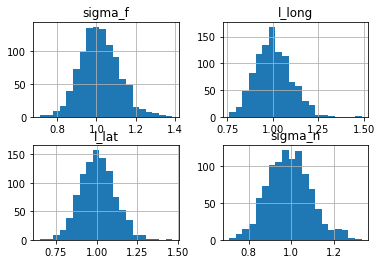

In [15]:
# Set Gaussian process to use maximum a posteriori hyperparameter values
sgpvi.set_max_post()

In [16]:
# Plot predictions from MAP hyperparameter estimates
sgpvi.plot_preds()

100.0% of data within 95% confidence interval


### 4.3. Posterior Credible Interval

In [17]:
sgpvi.plot_post()

Sampling posterior predictive distribution
sample 1
sample 101
sample 201
sample 301
sample 401
100.0% of data within 95% credible interval
Sampling posterior predictive distribution
sample 1
sample 101
sample 201
sample 301
sample 401
